In [1]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import cv2
import os

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
# faster rcnn model이 포함된 library
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import DataLoader, Dataset
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import wandb

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [13]:
## Cross Validation

import json 
import numpy as np 
from sklearn.model_selection import StratifiedGroupKFold 

annotation = '/opt/ml/detection/dataset/train.json'

with open(annotation) as f: data = json.load(f)

var = [(ann['image_id'], ann['category_id']) for ann in data['annotations']]
X = np.ones((len(data['annotations']),1))
y = np.array([v[1] for v in var])
groups = np.array([v[0] for v in var]) 

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=411) 

In [14]:
for train_idx, val_idx in cv.split(X, y, groups): 
    print("TRAIN:", groups[train_idx])
    print(" ", y[train_idx])
    print(" TEST:", groups[val_idx])
    print(" ", y[val_idx])

TRAIN: [   0    1    1 ... 4881 4881 4881]
  [0 3 7 ... 7 1 7]
 TEST: [   6   13   13 ... 4882 4882 4882]
  [1 6 7 ... 0 1 1]
TRAIN: [   0    1    1 ... 4882 4882 4882]
  [0 3 7 ... 0 1 1]
 TEST: [   5    5    5 ... 4876 4876 4878]
  [7 0 0 ... 0 2 0]
TRAIN: [   0    3    3 ... 4882 4882 4882]
  [0 2 6 ... 0 1 1]
 TEST: [   1    1    1 ... 4877 4877 4880]
  [3 7 4 ... 7 7 0]
TRAIN: [   1    1    1 ... 4882 4882 4882]
  [3 7 4 ... 0 1 1]
 TEST: [   0    3    3 ... 4881 4881 4881]
  [0 2 6 ... 7 1 7]
TRAIN: [   0    1    1 ... 4882 4882 4882]
  [0 3 7 ... 0 1 1]
 TEST: [   4    4    4 ... 4868 4872 4872]
  [1 1 1 ... 2 4 6]


In [19]:
from collections import Counter

def get_distribution(y): 
    y_distr = Counter(y)
    y_vals_sum = sum(y_distr.values()) 

    return [f'{y_distr[i]/y_vals_sum:.2%}' for i in range(np.max(y) +1)]



distrs = [get_distribution(y)]
index = ['training set']

for fold_ind, (train_idx, val_idx) in enumerate(cv.split(X,y, groups)): 
    train_y, val_y = y[train_idx], y[val_idx]
    train_gr, val_gr = groups[train_idx], groups[val_idx]

    assert len(set(train_gr) & set(val_gr)) == 0 
    distrs.append(get_distribution(train_y)) 
    distrs.append(get_distribution(val_y))
    index.append(f'train - fold{fold_ind}')
    index.append(f'val - fold{fold_ind}')
    
categories = [d['name'] for d in data['categories']] 
pd.DataFrame(distrs, index=index, columns = [categories[i] for i in range(np.max(y) + 1)])

,General trash,Paper,Paper pack,Metal,Glass,Plastic,Styrofoam,Plastic bag,Battery,Clothing
training set,17.14%,27.45%,3.88%,4.04%,4.24%,12.72%,5.46%,22.37%,0.69%,2.02%
train - fold0,16.96%,27.45%,3.79%,4.13%,4.48%,12.61%,5.51%,22.28%,0.77%,2.02%
val - fold0,17.85%,27.42%,4.23%,3.70%,3.26%,13.15%,5.25%,22.77%,0.35%,2.02%
train - fold1,17.14%,27.24%,4.01%,3.98%,4.28%,12.77%,5.38%,22.32%,0.67%,2.20%
val - fold1,17.12%,28.17%,3.41%,4.26%,4.12%,12.51%,5.72%,22.57%,0.73%,1.38%
train - fold2,17.31%,27.39%,3.83%,4.08%,4.13%,12.80%,5.14%,22.68%,0.69%,1.94%
val - fold2,16.42%,27.68%,4.05%,3.88%,4.70%,12.36%,6.76%,21.12%,0.69%,2.35%
train - fold3,17.30%,27.47%,3.87%,4.06%,4.22%,12.63%,5.49%,22.39%,0.63%,1.95%
val - fold3,16.50%,27.36%,3.88%,3.99%,4.33%,13.07%,5.33%,22.30%,0.92%,2.32%
train - fold4,16.97%,27.67%,3.88%,3.97%,4.10%,12.77%,5.76%,22.20%,0.68%,2.00%


In [109]:
# dataframe 생성

box_df = pd.DataFrame(data['annotations'])
box_df['x_min'] = box_df.bbox.apply(lambda x : x[0])
box_df['y_min'] = box_df.bbox.apply(lambda x : x[1])
box_df['height'] = box_df.bbox.apply(lambda x : x[2])
box_df['width'] = box_df.bbox.apply(lambda x : x[3])
box_df['x_max'] = box_df.x_min + box_df.height
box_df['y_max'] = box_df.y_min + box_df.width
box_df['ctr_x'] = box_df.x_min + box_df['height']/2
box_df['ctr_y'] = box_df.y_min + box_df['width']/2
box_df['ratio'] = box_df.height / box_df.width
box_df

,image_id,category_id,area,bbox,iscrowd,id,x_min,y_min,height,width,x_max,y_max,ctr_x,ctr_y,ratio
0,0,0,257301.66,"[197.6, 193.7, 547.8, 469.7]",0,0,197.6,193.7,547.8,469.7,745.4,663.4,471.50,428.55,1.166276
1,1,3,10402.56,"[0.0, 407.4, 57.6, 180.6]",0,1,0.0,407.4,57.6,180.6,57.6,588.0,28.80,497.70,0.318937
2,1,7,26259.36,"[0.0, 455.6, 144.6, 181.6]",0,2,0.0,455.6,144.6,181.6,144.6,637.2,72.30,546.40,0.796256
3,1,4,69096.17,"[722.3, 313.4, 274.3, 251.9]",0,3,722.3,313.4,274.3,251.9,996.6,565.3,859.45,439.35,1.088924
4,1,5,24164.58,"[353.2, 671.0, 233.7, 103.4]",0,4,353.2,671.0,233.7,103.4,586.9,774.4,470.05,722.70,2.260155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23139,4882,5,768591.81,"[0.0, 116.2, 944.1, 814.1]",0,23139,0.0,116.2,944.1,814.1,944.1,930.3,472.05,523.25,1.159686
23140,4882,7,57309.72,"[302.1, 439.3, 265.2, 216.1]",0,23140,302.1,439.3,265.2,216.1,567.3,655.4,434.70,547.35,1.227210
23141,4882,0,1772.74,"[511.3, 451.1, 58.7, 30.2]",0,23141,511.3,451.1,58.7,30.2,570.0,481.3,540.65,466.20,1.943709
23142,4882,1,53008.67,"[255.0, 421.4, 271.7, 195.1]",0,23142,255.0,421.4,271.7,195.1,526.7,616.5,390.85,518.95,1.392619


In [113]:
category_id = 1
box_df[box_df.category_id == category_id].describe()

,image_id,category_id,area,iscrowd,id,x_min,y_min,height,width,x_max,y_max,ctr_x,ctr_y,ratio
count,6352.000000,6352.0,6.352000e+03,6352.0,6352.000000,6352.000000,6352.000000,6352.000000,6352.000000,6352.000000,6352.000000,6352.000000,6352.000000,6352.000000
mean,2473.773142,1.0,9.204420e+04,0.0,11733.928999,384.916137,384.417774,263.851055,236.693168,648.767191,621.110941,516.841664,502.764358,1.391648
std,1413.570825,0.0,1.413165e+05,0.0,6694.346011,248.077456,209.957377,213.734364,190.071538,243.421307,224.051900,221.308798,195.214958,1.299488
min,4.000000,1.0,3.120000e+00,0.0,12.000000,0.000000,0.000000,1.300000,2.400000,14.900000,16.000000,7.450000,8.000000,0.059980
25%,1193.000000,1.0,9.473845e+03,0.0,5753.500000,192.800000,233.225000,96.800000,90.900000,474.700000,465.175000,369.225000,374.050000,0.745071
50%,2522.000000,1.0,3.564533e+04,0.0,11891.500000,360.400000,377.050000,202.500000,182.900000,673.500000,627.200000,512.225000,506.575000,1.110105
75%,3697.000000,1.0,1.149328e+05,0.0,17449.500000,559.025000,523.200000,368.400000,333.275000,839.175000,787.800000,665.575000,633.175000,1.622879
max,4882.000000,1.0,1.048064e+06,0.0,23143.000000,1011.300000,1010.000000,1023.900000,1023.800000,1023.900000,1024.000000,1017.500000,1016.850000,23.351351


<AxesSubplot:title={'center':'# of trash type'}, xlabel='category_id', ylabel='count'>

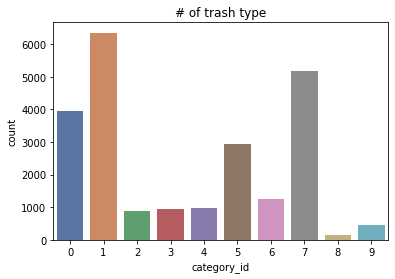

In [88]:
plt.title("# of trash type")
sns.countplot(box_df.category_id, palette = sns.color_palette('deep'))


<AxesSubplot:xlabel='ctr_y', ylabel='ctr_x'>

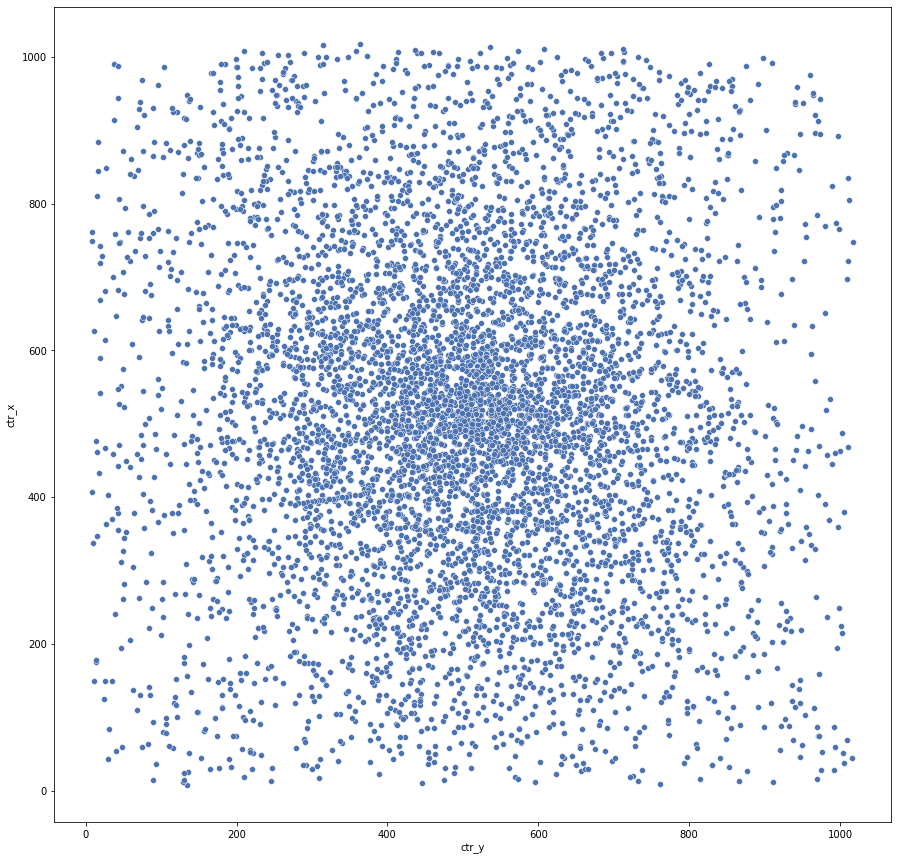

In [91]:
import seaborn as sns
color = sns.color_palette('deep')
plt.figure(figsize = (15,15))
sns.scatterplot(box_df[box_df.category_id == 1].ctr_y, box_df[box_df.category_id == 1].ctr_x, color = color[0])

<AxesSubplot:xlabel='ctr_y', ylabel='ctr_x'>

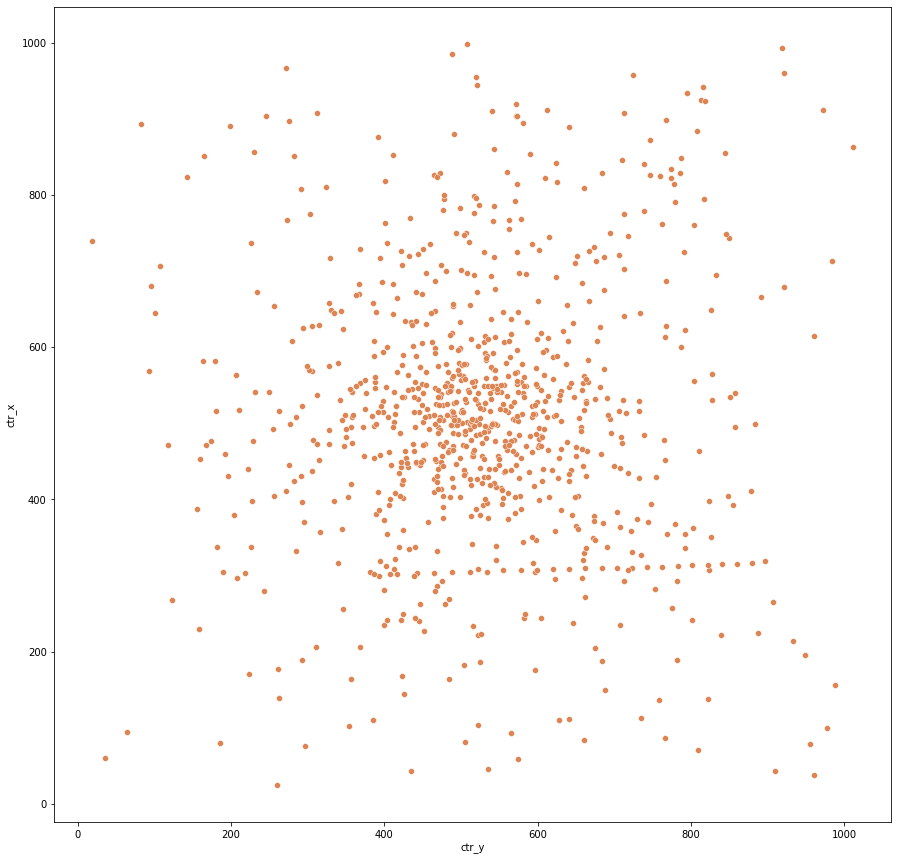

In [92]:
import seaborn as sns
color = sns.color_palette('deep')
plt.figure(figsize = (15,15))
sns.scatterplot(box_df[box_df.category_id == 2].ctr_y, box_df[box_df.category_id == 2].ctr_x, color = color[1])

<AxesSubplot:xlabel='ctr_y', ylabel='ctr_x'>

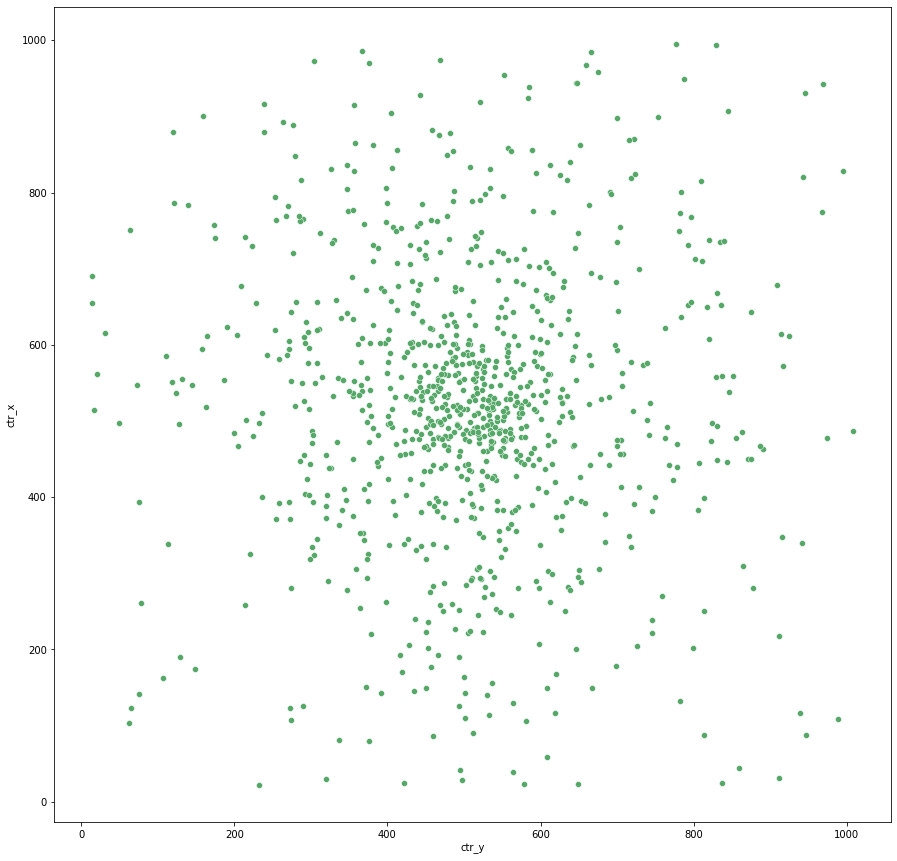

In [93]:
import seaborn as sns
color = sns.color_palette('deep')
plt.figure(figsize = (15,15))
sns.scatterplot(box_df[box_df.category_id == 3].ctr_y, box_df[box_df.category_id == 3].ctr_x, color = color[2])

<AxesSubplot:xlabel='ctr_y', ylabel='ctr_x'>

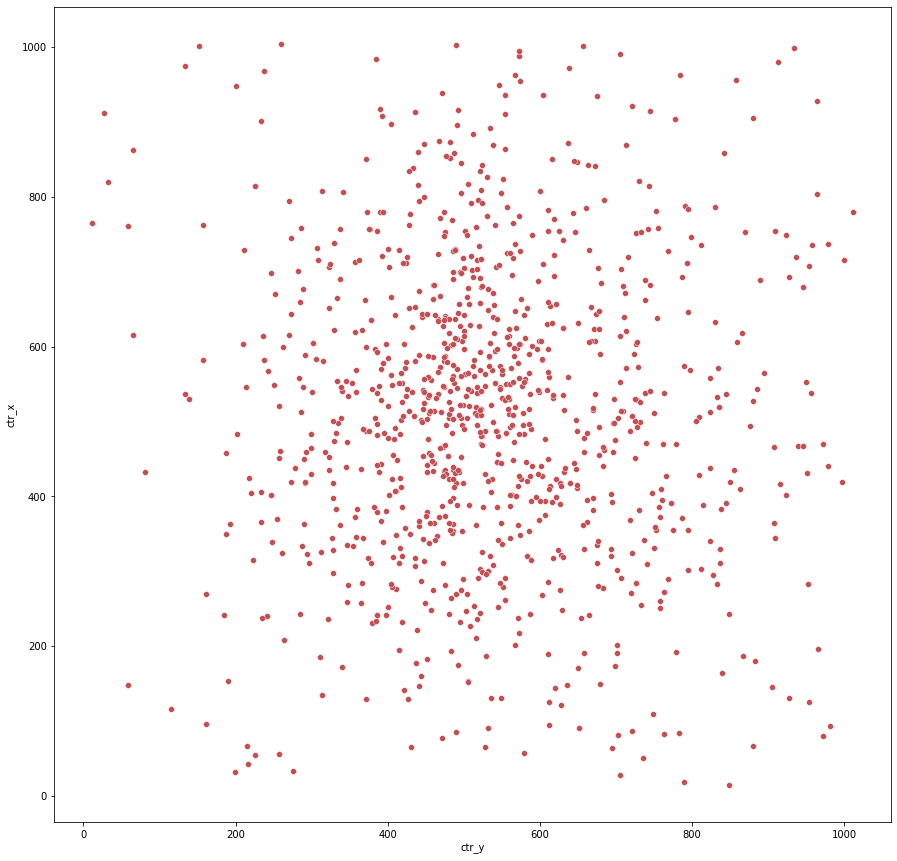

In [94]:
import seaborn as sns
color = sns.color_palette('deep')
plt.figure(figsize = (15,15))
sns.scatterplot(box_df[box_df.category_id == 4].ctr_y, box_df[box_df.category_id == 4].ctr_x, color = color[3])

<AxesSubplot:xlabel='ctr_y', ylabel='ctr_x'>

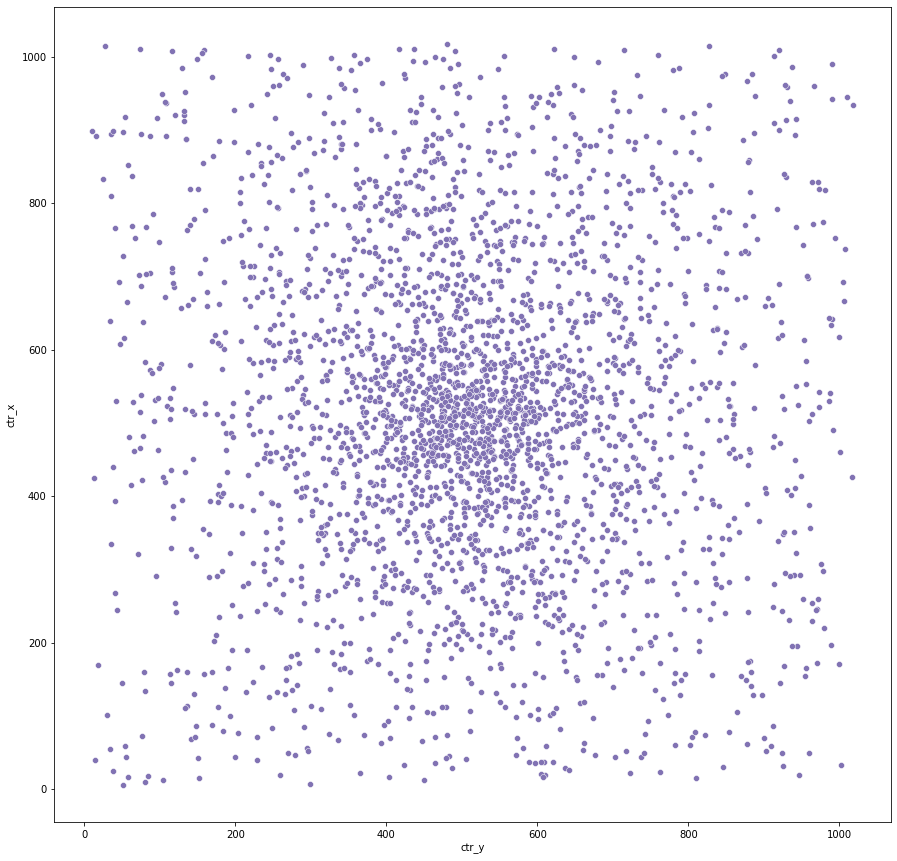

In [95]:
import seaborn as sns
color = sns.color_palette('deep')
plt.figure(figsize = (15,15))
sns.scatterplot(box_df[box_df.category_id == 5].ctr_y, box_df[box_df.category_id == 5].ctr_x, color = color[4])

<AxesSubplot:xlabel='ctr_y', ylabel='ctr_x'>

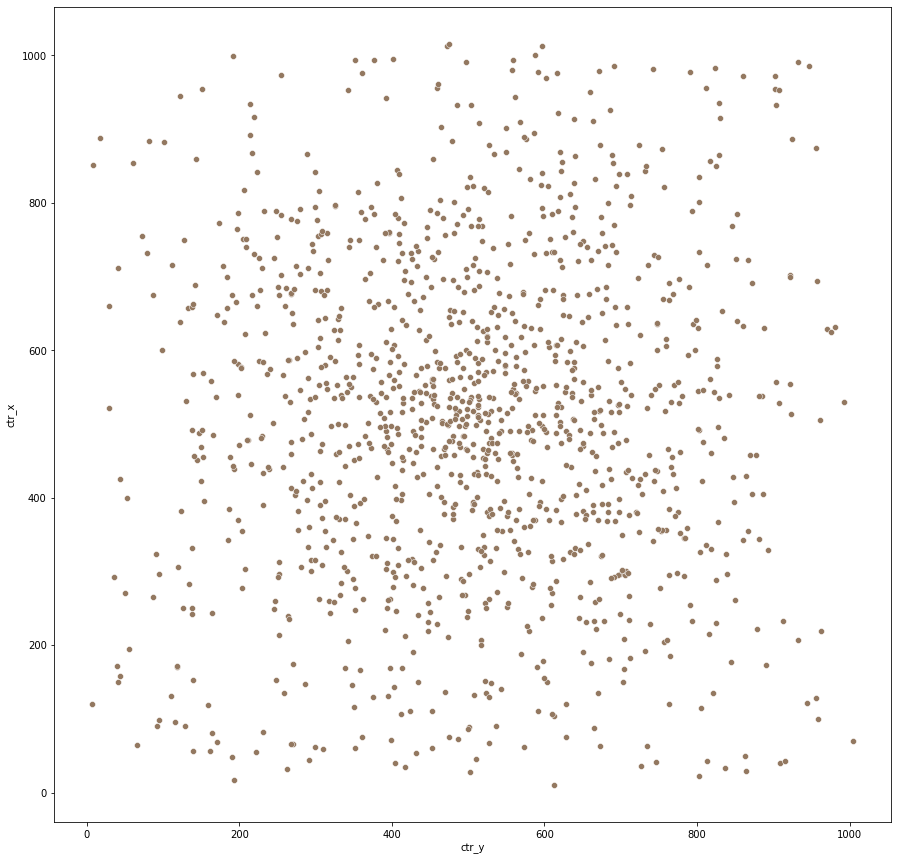

In [96]:
import seaborn as sns
color = sns.color_palette('deep')
plt.figure(figsize = (15,15))
sns.scatterplot(box_df[box_df.category_id == 6].ctr_y, box_df[box_df.category_id == 6].ctr_x, color = color[5])

<AxesSubplot:xlabel='ctr_y', ylabel='ctr_x'>

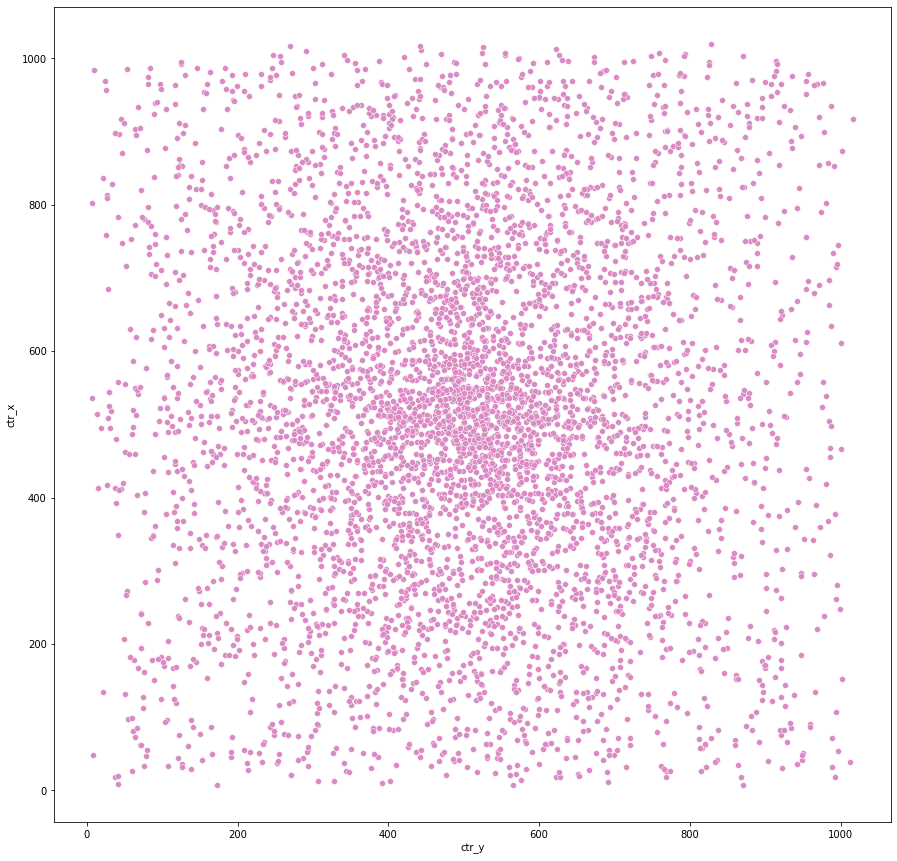

In [97]:
import seaborn as sns
color = sns.color_palette('deep')
plt.figure(figsize = (15,15))
sns.scatterplot(box_df[box_df.category_id == 7].ctr_y, box_df[box_df.category_id == 7].ctr_x, color = color[6])

<AxesSubplot:xlabel='ctr_y', ylabel='ctr_x'>

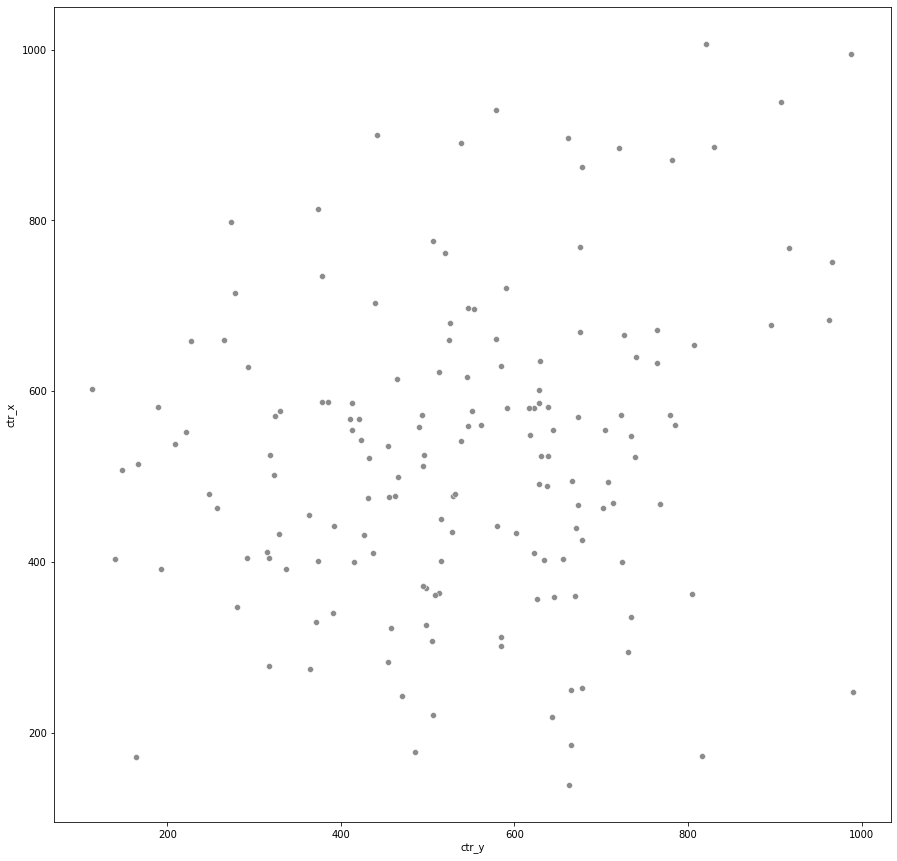

In [98]:
import seaborn as sns
color = sns.color_palette('deep')
plt.figure(figsize = (15,15))
sns.scatterplot(box_df[box_df.category_id == 8].ctr_y, box_df[box_df.category_id == 8].ctr_x, color = color[7])

<AxesSubplot:xlabel='ctr_y', ylabel='ctr_x'>

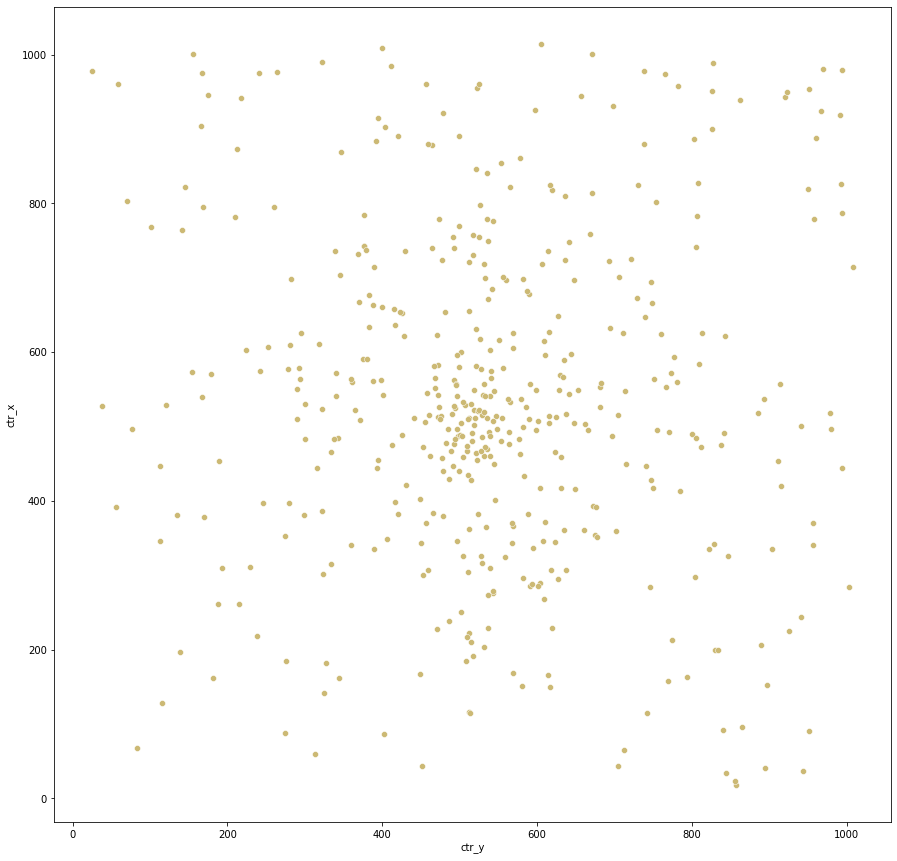

In [99]:
import seaborn as sns
color = sns.color_palette('deep')
plt.figure(figsize = (15,15))
sns.scatterplot(box_df[box_df.category_id == 9].ctr_y, box_df[box_df.category_id == 9].ctr_x, color = color[8])

<AxesSubplot:xlabel='ctr_y', ylabel='ctr_x'>

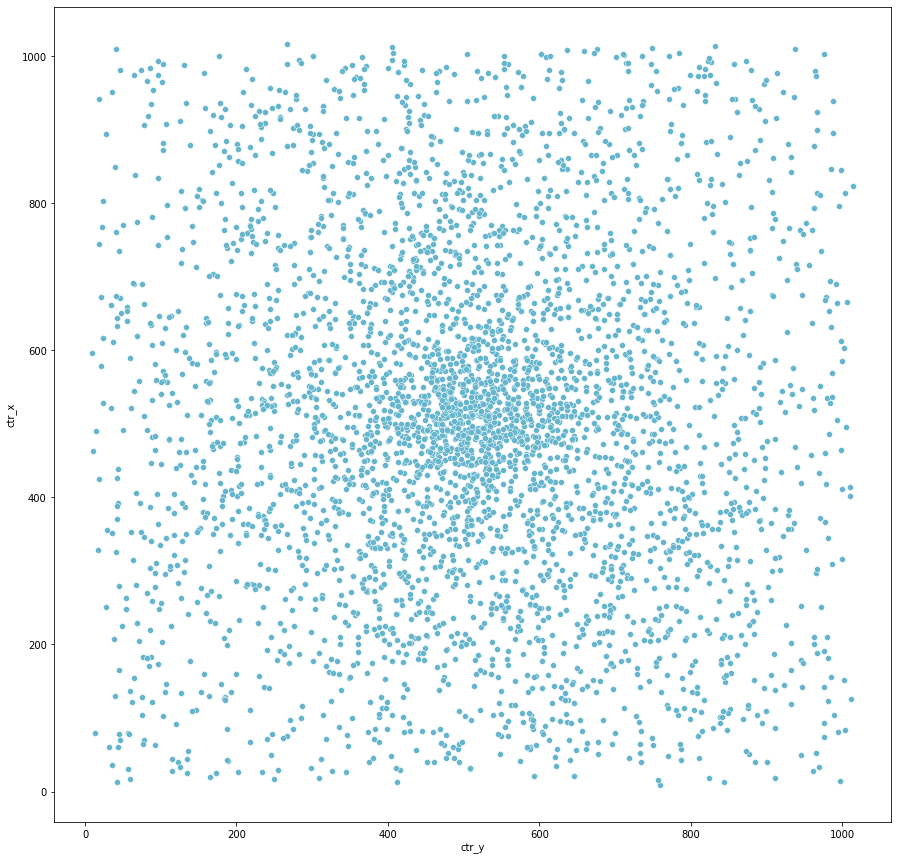

In [101]:
import seaborn as sns
color = sns.color_palette('deep')
plt.figure(figsize = (15,15))
sns.scatterplot(box_df[box_df.category_id == 0].ctr_y, box_df[box_df.category_id == 0].ctr_x, color = color[9])

In [103]:
# label별 height, width 평균
label_hw = box_df.groupby('category_id').mean()[["height","width"]]
label_hw

,height,width
category_id,,
0,226.237216,215.470096
1,263.851055,236.693168
2,244.896321,220.084504
3,251.029274,257.207051
4,206.087882,271.870876
5,239.375025,230.680632
6,299.147110,252.307126
7,275.377037,301.209579
8,228.874214,214.994969


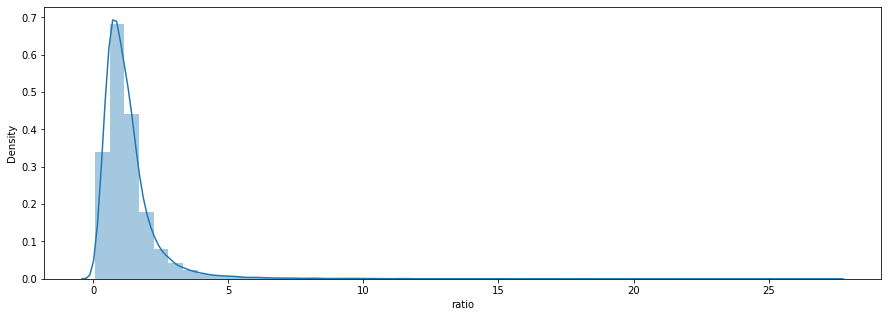

In [107]:
plt.figure(figsize=(15,5))
g = sns.distplot(box_df.ratio,)